In [33]:
import pysam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from icecream import ic
from Bio import SeqIO
from collections import defaultdict
from icecream import ic

# I now have a dataset that I can train an HMM on, let's see how it goes!

### Load Data

In [53]:

project_dir = Path('/data16/liam/working/data/alignments/250509_JANP-112_LT/')

bam = project_dir / '250509_JANP-112_LT.AtoG.sorted.bam'

both_bam = project_dir / 'demultiplexed_bams/bc6.bam' # both
oligo1_bam = project_dir / 'demultiplexed_bams/bc5.bam' # oligo1
oligo2_bam = project_dir / 'demultiplexed_bams/bc4.bam' # no ribosome
noOligo_bam = project_dir / 'demultiplexed_bams/bc3.bam' # time zero

merged_bam = project_dir / 'demultiplexed_bams/merged_barcodes.bam'
figures_dir = project_dir / 'figures'

out_dir = Path('/data16/liam/working/data/alignments/250509_JANP-112_LT/demultiplexed_bams/')
contig_pos_map = Path('/data16/liam/genomes/250401_translationSubstrate_pos_map.tsv')

reference = Path('/data16/liam/genomes/250401_dCDNA_translationSubstrates.fa')
assert reference.exists()
assert bam.exists()
assert out_dir.exists()
assert contig_pos_map.exists()

print('All files exist')

All files exist


In [54]:
ref_dict = SeqIO.to_dict(SeqIO.parse(reference, 'fasta'))
ref_seq = str(ref_dict['nanoluc_translatable'].seq)

In [55]:
# first lets get every read, identify edits, and convert the reads to binary strings. We'll want to do this by alignment
def get_binary_edit_string(bam, ref_sequence, chrom):
    '''
    For every read in a bam, this function will extract a binary string of A-G mismatches between the reference sequence and the read sequence.

    input: bam - path to the bam file
              ref_sequence - reference sequence
              aligned_pairs - list of aligned pairs
              start - start position of the region to extract
              end - end position of the region to extract
    output: dictionary with keys as the read names and values as the binary strings
    '''
    read_dict = {}
    for read in pysam.AlignmentFile(bam, "rb").fetch(chrom):
        
        if not read.is_unmapped:
            read_seq = read.query_sequence.upper()
            ref_seq = ref_sequence.upper()
            aligned_pairs = read.get_aligned_pairs()
            edits = []
            read_string = []
            ref_string = []
            barcode = read.get_tag('cI')

            for read_pos, ref_pos in aligned_pairs:
                if ref_pos is not None and read_pos is not None:
                    if ref_seq[ref_pos] == 'A' and read_seq[read_pos] == 'G':
                        edits.append(0.97)
                        read_string.append(read_seq[read_pos])
                        ref_string.append(ref_seq[ref_pos])
                    elif ref_seq[ref_pos] == 'A' and read_seq[read_pos] == 'A':
                        edits.append(0.03)
                        read_string.append(read_seq[read_pos])
                        ref_string.append(ref_seq[ref_pos])
                    else:
                        edits.append(0)
                        read_string.append(read_seq[read_pos])
                        ref_string.append(ref_seq[ref_pos])
            # convert the list of edits to a binary string
            # edit_string = ''.join(str(i) for i in edits)
            edits = np.array(edits)
            read_string = ''.join(str(i) for i in read_string)
            ref_string = ''.join(str(i) for i in ref_string)
            # print(read_string)
            # print(edit_string)
            # print(ref_string)
            # yield read.query_name, edit_string
            read_dict[read.query_name] = {
                'edits': edits,
                'read_string': ''.join(read_string),
                'ref_string': ''.join(ref_string),
                'start': read.reference_start,
                'end': read.reference_end,
                'barcode': barcode
            }
            
            
    return read_dict
    


In [56]:
read_dict = get_binary_edit_string(merged_bam, str(ref_seq), 'nanoluc_translatable')

### Cool, we now have a dictionary with read info, edit strings, and a barcode. These barcodes can serve as a ground truth
### Now we need to compute the score distribution. In Wang et al. they did this using the squiggles and a probability of a modification being real. I'm using A-G mismatches. In the past, this mismatch frequency was ~3% on non-edited reads

# HMM Functions

In [44]:
class Modification:
    '''
    Class to represent a modification
    '''
    def __init__(self, position, calling):
        self.position = position
        self.calling = calling

class BED:
    '''
    Class to represent an entry in a BED file
    '''
    def __init__(self, chro, start, end, quality, strand):
        self.chro = chro
        self.start = start
        self.end = end
        self.quality = quality
        self.strand = strand

In [45]:
def make_calling_vector(mod_list, read_length):
    calling_vec = [-1] * (read_length + 1)

    for m in mod_list:
        position = m.position
        calling = m.calling
        if 0 <= position <= read_length:
            calling_vec[position] = calling

    return calling_vec

In [46]:
scores = {}

for read in read_dict:
    read_info = read_dict[read]
    edit_string = read_info['edits']
    read_length = len(edit_string)
    s = [float(i) for i in edit_string]
    scores[read] = s


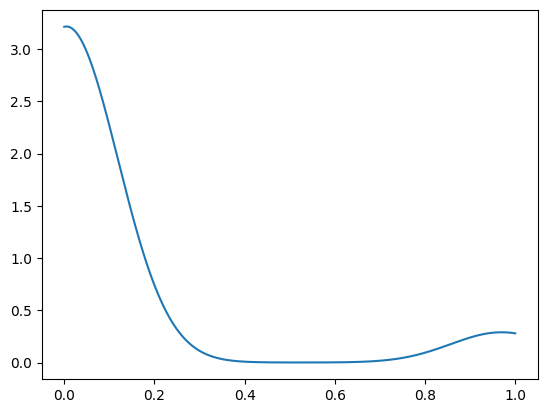

In [47]:
# plot score distribution 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace

score_list = []
for read, score in scores.items():
    score_list += score

score_list = np.array(score_list)
kde = gaussian_kde(score_list)



dist_space = linspace( 0, 1, 1000 )

plt.plot( dist_space, kde(dist_space) )

In [19]:
# vectorize kde function
vector = kde(dist_space)
print(len(vector))

1000


In [20]:
# write vector to file
with open('/data16/liam/testing/250604_JANP-112_kde_vector.txt', 'w') as f:
    for i in vector:
        f.write(str(i) + '\n')

### Score Distribution of Tad Accessible/Unaccessible Regions
#### with lower editing rates, the HMM tends to overpredict shadows. One idea we have is to introduce a tad accessibility score for kmers. This will enable us to enable multiple paths that we can iterate through with dynamic programming/backtracking algorithms to find the optimal path of shadows.
#### in real data, the accessibility score will likely be a measurement of base editor sequence preference, number of A's in kmer, and number of edits in kmer (in shadowless data)
#### in simulated data, I will just use number of As in kmer

In [63]:
# need to compute 3mer sequence bias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import pysam
from Bio import SeqIO

def ParseCigar_minusFeature(read_seq, ref_seq, cigar, ref_start, ref_end, q_st, q_en):
    import re
    parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', cigar)
    parsed_cigar = [(int(num), char) for num, char in parsed_cigar]
    ref_seq = ref_seq[int(ref_start):int(ref_end)].upper()
    ref_pos = 0
    read_seq = read_seq[int(q_st):int(q_en)].upper()
    read_pos = 0

    top_line = ""
    middle_line = ""
    bottom_line = ""
    
    for length, code in parsed_cigar:
        if code == "M":  # Map (Read & Ref Match)
            read_map_piece = read_seq[read_pos:read_pos + length]
            ref_map_piece = ref_seq[ref_pos:ref_pos + length]
            perfect_matches = ""
            for index, char in enumerate(read_map_piece):
                try:
                    if char == ref_map_piece[index]:
                        perfect_matches += "|"
                    else:
                        perfect_matches += "•"
                except IndexError:
                    perfect_matches += " "
            top_line += read_map_piece
            middle_line += perfect_matches
            bottom_line += ref_map_piece
            ref_pos += length
            read_pos += length

        elif code == "I":  # Insert (Gap in Ref)
            top_line += read_seq[read_pos:read_pos + length]
            middle_line += " " * length
            bottom_line += " " * length
            read_pos += length

        elif code == "D" or code == "N":  # Delete (Gap in Read)
            top_line += " " * length
            middle_line += " " * length
            bottom_line += ref_seq[ref_pos:ref_pos + length]
            ref_pos += length

    return top_line, middle_line, bottom_line

def FindMods(read_line, match_line, ref_line, strand:bool):
    modList = []
    if strand == True: #reads are reverse complemented and mutated from A-G
        for i in range(len(read_line)):
            if read_line[i] == 'G' and ref_line[i] == 'A':  
                modList.append(1)
            else:
                modList.append(0)
    return modList
                
def get_3mers(ref_line, modList):
    # Initialize Dictionary of 3mers to hold edit counts
    L_bases = ["A", "C", "G", "T"]
    L_substitutions = [base1+'A'+base2 for base1 in L_bases for base2 in L_bases]
    three_mer_dict = {}
    for substitution in L_substitutions:
        three_mer_dict[substitution] = [0,0] # [numEdits at 3mer, num 3mers in region]
    
    for i in range(len(ref_line)-3):
        kmer = ref_line[i:i+3]
        # if kmer in three_mer_dict
        if kmer in three_mer_dict:
            three_mer_dict[kmer][1] += 1


    # Iterate through each base in the read and compare to the reference
    for i in range(len(modList)):
        if modList[i] > 0.9:
            # get 3mer
            kmer = ref_line[i-1:i+2]
            # add to count
            if kmer in three_mer_dict:
                three_mer_dict[kmer][0] += 1

    return three_mer_dict
    
            
def plot_thee_mer_bias(library_threeMer_dict, outFile):
    L_bases = ["A", "C", "G", "T"]
    L_substitutions = [base1+'A'+base2 for base1 in L_bases for base2 in L_bases]
    plot_dict = {}
    tmp_dict = {}
    cumulative_totals = {}

    for substitution in L_substitutions:
        tmp_dict[substitution] = [0,0] # [numEdits at 3mer, num 3mers in region]

    for substitution in L_substitutions:
        plot_dict[substitution] = 0 # Edits per 3mer/3mers 

    for substitution in L_substitutions:
        cumulative_totals[substitution] = 0 # num 3mers 


    # collapse all edits and sites into cumulative counts
    for read in library_threeMer_dict:
        for kmer in library_threeMer_dict[read]:
            if kmer in plot_dict:
                tmp_dict[kmer][0] += library_threeMer_dict[read][kmer][0]
                tmp_dict[kmer][1] += library_threeMer_dict[read][kmer][1]
                

    for kmer in tmp_dict:
        if tmp_dict[kmer][0] != 0 and tmp_dict[kmer][1] != 0:
            plot_dict[kmer] = tmp_dict[kmer][0]/tmp_dict[kmer][1]
           
        # plot_dict[kmer][0] += tmp_dict[kmer][0][0]/tmp_dict[kmer][0][1]
        # plot_dict[kmer][1] += tmp_dict[kmer][1][0]/tmp_dict[kmer][1][1]

    for kmer in tmp_dict:
        cumulative_totals[kmer] += tmp_dict[kmer][1]
        

    print(plot_dict)
    edit_df = pd.DataFrame(plot_dict.items())
    edit_df.columns = ['3mer', 'Frac']
    edit_df = edit_df.explode('Frac').reset_index(drop=True)
    # edit_df['Gene Region']=np.where(edit_df.index%2==0, 'CDS', 'UTR') 

    totals_df = pd.DataFrame(cumulative_totals.items())
    totals_df.columns = ['3mer', 'Totals']
    totals_df = totals_df.explode('Totals').reset_index(drop=True)
    # totals_df['Gene Region']=np.where(totals_df.index%2==0, 'CDS', 'UTR')

    # plot
    figureHeight = 6
    figureWidth = 17
    plt.figure(figsize=(figureWidth, figureHeight))
    panelHeight = 5 / figureHeight
    panelWidth = 6 / figureWidth

    panel1 = plt.axes([0.05, 0.1, panelWidth, panelHeight])
    panel1 = sns.barplot(data=edit_df, x="3mer", y="Frac", palette="dark")
   

    panel1.set_xlabel("3mer")
    panel1.set_ylabel("Edits per 3mer in region / 3mers in region")
    panel1.set_title("3mer bias")

    panel2 = plt.axes([0.55, 0.1, panelWidth, panelHeight])
    panel2 = sns.barplot(data=totals_df, x="3mer", y="Totals", palette="dark")
    
    
    panel2.set_xlabel("3mer")
    panel2.set_ylabel("Number of 3mers in region")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    panel2.set_title("Total 3mers in Gene Region")

    plt.savefig(outFile, dpi=600)

    return plot_dict


In [59]:
library_threeMer_dict = {}
for read in read_dict:
    read_info = read_dict[read]
    read_seq = read_info['read_string']
    ref_seq = read_info['ref_string']
    edits = read_info['edits']
    start = read_info['start']
    end = read_info['end']
    barcode = read_info['barcode']

    # # parse cigar
    # top_line, middle_line, bottom_line = ParseCigar_minusFeature(read_seq, ref_seq, read.cigarstring, start, end, 0, len(read_seq))
    
    # # find mods
    # modList = FindMods(top_line, middle_line, bottom_line, True)
    
    # get 3mers
    # print(read_seq)
    # print(''.join(str(i) for i in edits))
    # print(ref_seq)
    three_mer_dict = get_3mers(ref_seq, edits)
    # add to library dict   
    library_threeMer_dict[read] = three_mer_dict

      

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'AAA': 0.9558727711052711, 'AAC': 0.7432190480845206, 'AAG': 0.8237028389321549, 'AAT': 0.8771654120311771, 'CAA': 0.7659837756084147, 'CAC': 0.7382716246494128, 'CAG': 0.6920421850357, 'CAT': 0.8947572735941978, 'GAA': 0.7414222442051305, 'GAC': 0.8919079972010925, 'GAG': 0.9310720968191409, 'GAT': 0.8496328771330902, 'TAA': 0.9295025970901428, 'TAC': 0.8219617660446062, 'TAG': 0.8479416556034158, 'TAT': 0.9176696500213096}


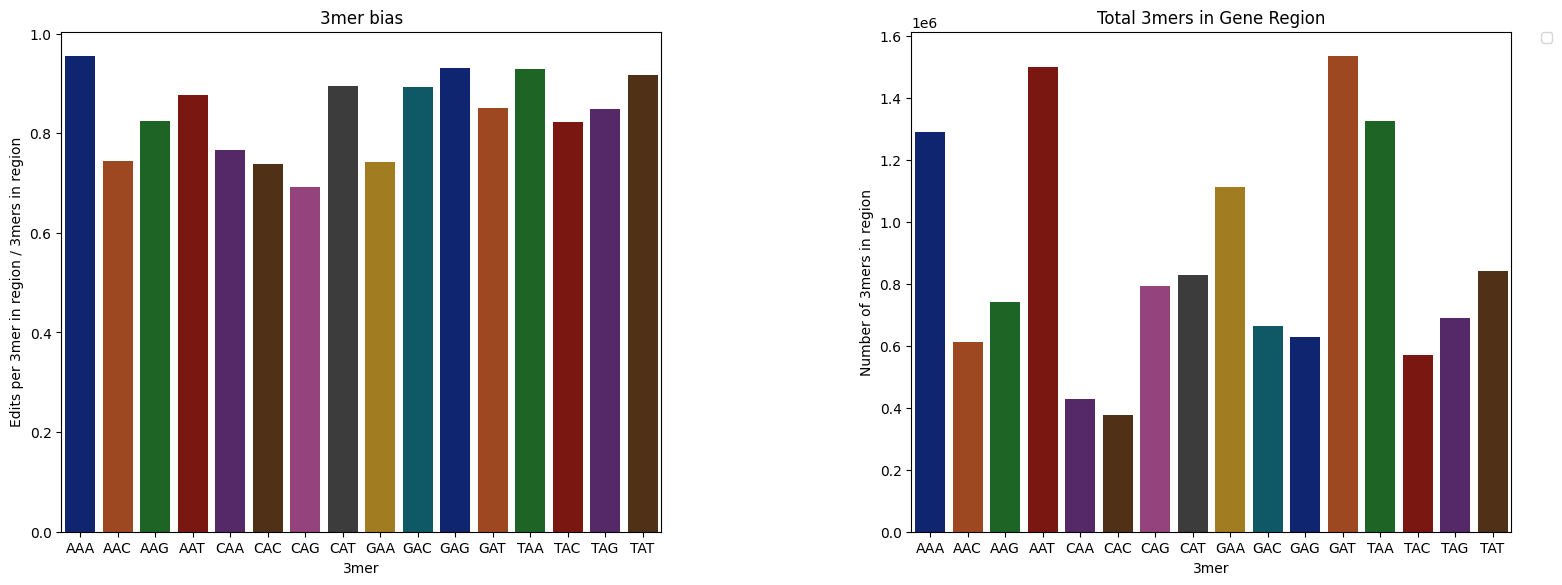

In [64]:
threemer_dict = plot_thee_mer_bias(library_threeMer_dict, figures_dir / '250605_3mer_bias.png')

In [68]:
# let's use 3mer bias to compute tad accessibility
tad_access_scores = {}

# mod_map, read_dict = build_modification_map2(f)
for read in read_dict:
    query_seq = read_dict[read]['read_string']
    ref_seq = read_dict[read]['ref_string']
    kmer_dict = {}
    for i in range(len(query_seq)-3):
        kmer = query_seq[i:i+3]
        # # count number of A's in kmer
        # num_A = 0
        # for base in range(len(kmer)):
        #     if i + base in read_dict[read][2]:
        #         num_A += 1

        # # calculate TAD access score
        # tad_access_score = num_A / len(kmer)
        # # calculate TAD inaccess score
        # tad_inaccess_score = (len(kmer) - num_A) / len(kmer) 
        if kmer in threemer_dict:
            tad_access_score = threemer_dict[kmer] # get the 3mer score from the threemer_dict
            tad_inaccess_score = 1 - tad_access_score # inaccessibility is the inverse of accessibility
        else:
            # count number of A's in kmer
            num_A = kmer.count('A')
            # calculate TAD access score
            tad_access_score = num_A / len(kmer)
            # calculate TAD inaccess score
            tad_inaccess_score = (len(kmer) - num_A) / len(kmer)  


        # kmer_name = ''.join(str(i) for i in kmer)
        # kmer_name = str(i) + '_' + str(i+6)
        if kmer not in kmer_dict:
            kmer_dict[kmer] = (tad_access_score, tad_inaccess_score)
        # else:
        #     kmer_dict[kmer_name] = (kmer_dict[kmer_name][0] * tad_access_score, kmer_dict[kmer_name][1] * tad_inaccess_score)

    tad_access_scores[read] = kmer_dict

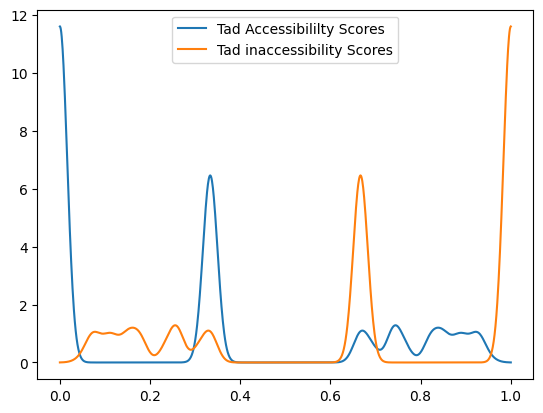

In [69]:
# plot score distribution 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace

access_scores = []
inaccess_scores = []
for read in tad_access_scores:
    for kmer in tad_access_scores[read]:
        access_scores.append(tad_access_scores[read][kmer][0])
        inaccess_scores.append(tad_access_scores[read][kmer][1])


access_scores = np.array(access_scores)
inaccess_scores = np.array(inaccess_scores)

kde = gaussian_kde(access_scores)
kde2 = gaussian_kde(inaccess_scores)


dist_space = linspace( 0, 1, 1000 )

plt.plot( dist_space, kde(dist_space) )
plt.plot( dist_space, kde2(dist_space) )
plt.legend(['Tad Accessibililty Scores', 'Tad inaccessibility Scores'])

In [71]:
# write to pickle
import pickle
with open('/data16/liam/testing/JANP-112_tad_access_scores.pkl', 'wb') as f:
    pickle.dump(tad_access_scores, f)

# Build Transition and Probability Matrices
### HMM with emission matrix from score distribution

In [ ]:
# mod_file = '/data16/liam/testing/HMM_test_data_10.txt'
# pred_file = '/data16/liam/testing/HMM_test_data_pred_10_kde.txt'

# emission_pos_file = '/data16/liam/testing/kde_vector_10.txt'
# emission_neg_file = '/data16/liam/testing/kde_vector_mock.txt'
mod_file = '/data16/liam/testing/HMM_test_data_20.txt'
pred_file = '/data16/liam/testing/241210_HMM_test_data_pred_20_kde.txt'

emission_pos_file = '/data16/liam/testing/kde_vector_20.txt'
emission_neg_file = '/data16/liam/testing/kde_vector_mock.txt'

emission_pos_array = []
with open(emission_pos_file) as f:
    for line in f:
        emission_pos_array.append(float(line.rstrip()))
emission_pos_array = np.array(emission_pos_array)
emission_neg_array = []
with open(emission_neg_file) as f:
    for line in f:
        emission_neg_array.append(float(line.rstrip()))
emission_neg_array = np.array(emission_neg_array)

# get access scores from pickle
with open('/data16/liam/testing/tad_access_scores_20.pkl', 'rb') as f:
    tad_access_scores = pickle.load(f)